<a href="https://colab.research.google.com/github/issa-rashdan/INFORM_Project_M/blob/main/data_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/issa-rashdan/INFORM_Project_M.git

Cloning into 'INFORM_Project_M'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 145 (delta 52), reused 68 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 125.67 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (52/52), done.


# Getting Echograms

In [3]:
import numpy as np
from INFORM_Project_M.data.echosounder_data.load_data.get_echograms_2 import get_echograms, count_classes_in_echograms

# You can select a specific year or use 'all' to include multiple years.
years = 2014
minimum_shape = 224
tuple_frequencies = (18, 38, 70, 120, 200, 333)
echograms = get_echograms(years=years, tuple_frequencies=tuple_frequencies, minimum_shape=minimum_shape)
print(f"Number of echograms: {len(echograms)}")

Selected 10 echograms from year 2014
Number of echograms: 10


# Data split into Train and Test

In [4]:
import os
import random
# Randomly split echograms into train/test
random.seed(42)  # Set a seed for reproducibility
Train_eg = []
test_eg = []
echogram = random.shuffle(echograms)  # Shuffle echograms randomly
for i,echogram in enumerate(echograms):
  if i < 0.8*len(echograms):
    Train_eg.append(echogram)
  else:
    test_eg.append(echogram)

#Save the echograms to files
train_dir = '/content/INFORM_Project_M/train'
test_dir = '/content/INFORM_Project_M/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, echogram in enumerate(Train_eg):
 os.path.join(train_dir, f'echogram_{i}.npy')
for i, echogram in enumerate(test_eg):
  os.path.join(test_dir, f'echogram_{i}.npy')

# Print the number of echograms in each set
print('Train Echogram:', len(Train_eg))
print('Test Echogram:', len(test_eg))

Train Echogram: 8
Test Echogram: 2


# Data Patching

In [5]:
from INFORM_Project_M.data.echosounder_data.preprocessing.resize_and_crop import SplitResizeEchogram, generate_patch_batches
from INFORM_Project_M.data.echosounder_data.preprocessing.normalization import db, clip, standardize_min_max
import numpy as np

data_transform = [db, clip, standardize_min_max]
split_patch_size = 448
output_patch_size = 448


#---Train set---
train_generators, num_patches_per_train_echogram = generate_patch_batches(Train_eg, split_patch_size,
                                                                          output_patch_size, data_transforms= data_transform,
                                                                          batch_size='full', verbose= False)
print('Number of patches per echogram for training:', num_patches_per_train_echogram )

#---Test set---
generators_test, num_patches_per_test_echogram = generate_patch_batches(test_eg, split_patch_size, output_patch_size,
                                                                        data_transforms= data_transform,
                                                                        batch_size='full', verbose= False)
print('Number of patches per echogram for testing:', num_patches_per_train_echogram )

train_patches = 0
test_patches = 0
for patches in num_patches_per_train_echogram:
  train_patches += patches
for patches in num_patches_per_test_echogram:
  test_patches += patches
print('Number of patches in training set:', train_patches)
print('Number of patches in test set:', test_patches)

Number of patches per echogram for training: [np.int64(37), np.int64(7), np.int64(8), np.int64(7), np.int64(10), np.int64(16), np.int64(10), np.int64(8)]
Number of patches per echogram for testing: [np.int64(37), np.int64(7), np.int64(8), np.int64(7), np.int64(10), np.int64(16), np.int64(10), np.int64(8)]
Number of patches in training set: 103
Number of patches in test set: 24


# dimensionality reduction 6 to 3

In [6]:
from INFORM_Project_M.data.echosounder_data.dataloader import BatchGeneratorDataset, GroupedGenerator, group_generators_by_patch_limit
from INFORM_Project_M.adaptation_method.model_config import Configuration
from torch.utils.data import DataLoader
import torch
import numpy as np


run = Configuration()
#---Training set---
print('-------Dimensions for Training set-------------')
grouped_generator_fns, grouped_patch_count = group_generators_by_patch_limit(train_generators,
                                                                             num_patches_per_train_echogram,
                                                                             64)
train_dataset = BatchGeneratorDataset(grouped_generator_fns)
train_loader = DataLoader(train_dataset, batch_size = None, pin_memory=True)

for label, data, mask in train_loader:
  print(data.shape)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: issa-rashdan (issa-rashdan-university-of-oslo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------Dimensions for Training set-------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([59, 6, 448, 448])
torch.Size([44, 6, 448, 448])


In [7]:
#---Test Set---
print('-------Dimensions for Test set-------------')
grouped_generator_fns_test, grouped_patch_count_test = group_generators_by_patch_limit(generators_test,
                                                                                       num_patches_per_test_echogram,
                                                                                       64)
test_dataset = BatchGeneratorDataset(grouped_generator_fns_test)
test_loader = DataLoader(test_dataset, batch_size = None, pin_memory= True)

for label, data, mask in test_loader:
  print(data.shape)

-------Dimensions for Test set-------------
torch.Size([24, 6, 448, 448])


Epoch 1/30: 100%|██████████| 2/2 [01:26<00:00, 43.43s/it]


Train encodings: min=0.0173, max=0.9654
Val latents: min=0.0361, max=0.9278
 Train Loss = 0.1038 ,Validation Loss = 0.0799


Epoch 2/30: 100%|██████████| 2/2 [01:15<00:00, 37.67s/it]


Train encodings: min=0.0447, max=0.9106
Val latents: min=0.0484, max=0.9031
 Train Loss = 0.0815 ,Validation Loss = 0.0661


Epoch 3/30: 100%|██████████| 2/2 [01:15<00:00, 37.75s/it]


Train encodings: min=0.0651, max=0.8676
Val latents: min=0.0580, max=0.8839
 Train Loss = 0.0702 ,Validation Loss = 0.0480


Epoch 4/30: 100%|██████████| 2/2 [01:15<00:00, 37.75s/it]


Train encodings: min=0.0676, max=0.8600
Val latents: min=0.0592, max=0.8815
 Train Loss = 0.0589 ,Validation Loss = 0.0390


Epoch 5/30: 100%|██████████| 2/2 [01:14<00:00, 37.10s/it]


Train encodings: min=0.0652, max=0.8616
Val latents: min=0.0552, max=0.8897
 Train Loss = 0.0434 ,Validation Loss = 0.0323


Epoch 6/30: 100%|██████████| 2/2 [01:16<00:00, 38.13s/it]


Train encodings: min=0.0594, max=0.8744
Val latents: min=0.0506, max=0.8988
 Train Loss = 0.0409 ,Validation Loss = 0.0282


Epoch 7/30: 100%|██████████| 2/2 [01:14<00:00, 37.27s/it]


Train encodings: min=0.0543, max=0.8877
Val latents: min=0.0438, max=0.9124
 Train Loss = 0.0320 ,Validation Loss = 0.0236


Epoch 8/30: 100%|██████████| 2/2 [01:22<00:00, 41.05s/it]


Train encodings: min=0.0491, max=0.9009
Val latents: min=0.0426, max=0.9148
 Train Loss = 0.0261 ,Validation Loss = 0.0235


Epoch 9/30: 100%|██████████| 2/2 [01:14<00:00, 37.36s/it]


Train encodings: min=0.0482, max=0.9036
Val latents: min=0.0431, max=0.9138
 Train Loss = 0.0283 ,Validation Loss = 0.0221


Epoch 10/30: 100%|██████████| 2/2 [01:14<00:00, 37.43s/it]


Train encodings: min=0.0506, max=0.8987
Val latents: min=0.0460, max=0.9080
 Train Loss = 0.0263 ,Validation Loss = 0.0248


Epoch 11/30: 100%|██████████| 2/2 [01:15<00:00, 37.89s/it]


Train encodings: min=0.0490, max=0.9019
Val latents: min=0.0435, max=0.9130
 Train Loss = 0.0230 ,Validation Loss = 0.0182


Epoch 12/30: 100%|██████████| 2/2 [01:14<00:00, 37.24s/it]


Train encodings: min=0.0468, max=0.9064
Val latents: min=0.0404, max=0.9192
 Train Loss = 0.0219 ,Validation Loss = 0.0231


Epoch 13/30: 100%|██████████| 2/2 [01:16<00:00, 38.09s/it]


Train encodings: min=0.0403, max=0.9194
Val latents: min=0.0321, max=0.9357
 Train Loss = 0.0208 ,Validation Loss = 0.0223


Epoch 14/30: 100%|██████████| 2/2 [01:14<00:00, 37.16s/it]


Train encodings: min=0.0304, max=0.9392
Val latents: min=0.0229, max=0.9542
 Train Loss = 0.0227 ,Validation Loss = 0.0211


Epoch 15/30: 100%|██████████| 2/2 [01:21<00:00, 40.70s/it]


Train encodings: min=0.0209, max=0.9583
Val latents: min=0.0156, max=0.9688
 Train Loss = 0.0212 ,Validation Loss = 0.0166


Epoch 16/30: 100%|██████████| 2/2 [01:17<00:00, 38.63s/it]


Train encodings: min=0.0165, max=0.9670
Val latents: min=0.0140, max=0.9720
 Train Loss = 0.0185 ,Validation Loss = 0.0187


Epoch 17/30: 100%|██████████| 2/2 [01:14<00:00, 37.35s/it]


Train encodings: min=0.0159, max=0.9681
Val latents: min=0.0143, max=0.9714
 Train Loss = 0.0193 ,Validation Loss = 0.0164


Epoch 18/30: 100%|██████████| 2/2 [01:20<00:00, 40.31s/it]


Train encodings: min=0.0176, max=0.9648
Val latents: min=0.0175, max=0.9650
 Train Loss = 0.0182 ,Validation Loss = 0.0165


Epoch 19/30: 100%|██████████| 2/2 [01:14<00:00, 37.28s/it]


Train encodings: min=0.0224, max=0.9552
Val latents: min=0.0256, max=0.9488
 Train Loss = 0.0173 ,Validation Loss = 0.0164


Epoch 20/30: 100%|██████████| 2/2 [01:15<00:00, 37.75s/it]


Train encodings: min=0.0326, max=0.9348
Val latents: min=0.0401, max=0.9197
 Train Loss = 0.0167 ,Validation Loss = 0.0157


Epoch 21/30: 100%|██████████| 2/2 [01:14<00:00, 37.01s/it]


Train encodings: min=0.0494, max=0.9012
Val latents: min=0.0588, max=0.8824
 Train Loss = 0.0160 ,Validation Loss = 0.0157


Epoch 22/30: 100%|██████████| 2/2 [01:19<00:00, 39.70s/it]


Train encodings: min=0.0655, max=0.8690
Val latents: min=0.0676, max=0.8649
 Train Loss = 0.0152 ,Validation Loss = 0.0154


Epoch 23/30: 100%|██████████| 2/2 [01:16<00:00, 38.45s/it]


Train encodings: min=0.0669, max=0.8661
Val latents: min=0.0661, max=0.8677
 Train Loss = 0.0150 ,Validation Loss = 0.0144


Epoch 24/30: 100%|██████████| 2/2 [01:14<00:00, 37.07s/it]


Train encodings: min=0.0651, max=0.8698
Val latents: min=0.0636, max=0.8729
 Train Loss = 0.0144 ,Validation Loss = 0.0143


Epoch 25/30: 100%|██████████| 2/2 [01:13<00:00, 36.98s/it]


Train encodings: min=0.0663, max=0.8673
Val latents: min=0.0676, max=0.8647
 Train Loss = 0.0139 ,Validation Loss = 0.0141


Epoch 26/30: 100%|██████████| 2/2 [01:13<00:00, 36.99s/it]


Train encodings: min=0.0739, max=0.8523
Val latents: min=0.0753, max=0.8493
 Train Loss = 0.0133 ,Validation Loss = 0.0140


Epoch 27/30: 100%|██████████| 2/2 [01:13<00:00, 36.91s/it]


Train encodings: min=0.0799, max=0.8403
Val latents: min=0.0796, max=0.8409
 Train Loss = 0.0129 ,Validation Loss = 0.0139


Epoch 28/30: 100%|██████████| 2/2 [01:15<00:00, 37.68s/it]


Train encodings: min=0.0806, max=0.8387
Val latents: min=0.0774, max=0.8451
 Train Loss = 0.0125 ,Validation Loss = 0.0134


Epoch 29/30: 100%|██████████| 2/2 [01:13<00:00, 36.60s/it]


Train encodings: min=0.0783, max=0.8434
Val latents: min=0.0757, max=0.8485
 Train Loss = 0.0122 ,Validation Loss = 0.0128


Epoch 30/30: 100%|██████████| 2/2 [01:22<00:00, 41.20s/it]


Train encodings: min=0.0786, max=0.8428
Val latents: min=0.0806, max=0.8389
 Train Loss = 0.0115 ,Validation Loss = 0.0128


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.01149
val_loss,0.01277


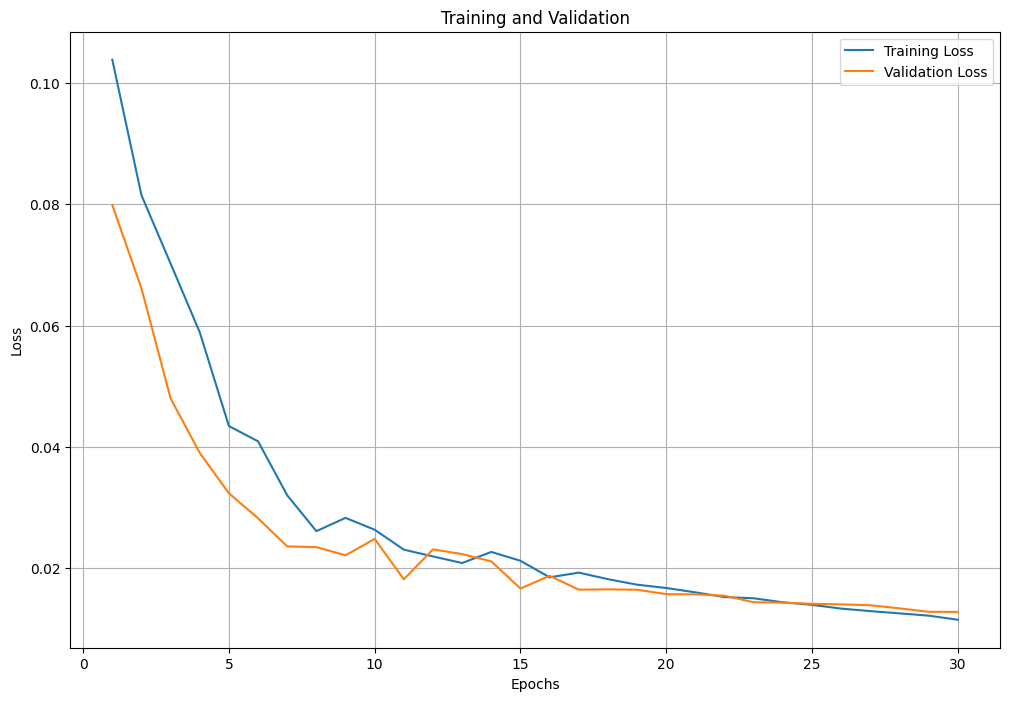

In [8]:
from INFORM_Project_M.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from INFORM_Project_M.adaptation_method.Autoencoder import Autoencoder
import torch.nn as nn
import torch.optim as optim

#For logging
run = Configuration(model_name = 'Autoencoder')

#Instantiating model
model = Autoencoder()



# Defining Loss function and optimizer
Loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = run.config['learning_rate'], weight_decay = run.config['Weight_decay'])

latent,  val_latent, avg_loss_train, avg_loss_val, stop_epoch = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, stop_epoch)